In [4]:
#The first step is importing the necessary modules along with %matplotlib inline
#so plots appear in  the notebook without calling plt.show() for each plot.

import numpy as np #for arrays
import pandas as pd #for dataframes
import matplotlib.pyplot as plt #for graphing/visualization
import seaborn as sns #to supplement plt
import scipy.stats as stats #for statistical analysis
%matplotlib inline 

#Then, import the excel data using pandas. The excel file is added, and then the different sheets read separately.

xls = pd.ExcelFile('Ramen Full List 2022.03.09.xlsx')
dfrev=pd.read_excel(xls,'Reviewed')
dfran=pd.read_excel(xls,'Ranking')
dfctr=pd.read_excel(xls,'Country Info')
dfcon=pd.read_excel(xls,'Instant Noodle Consumption')
dfurl=pd.read_excel(xls,'URL')

In [2]:
#The next step is cleaning up some of the datatypes in the dataframes (after verifying them with .dtypes, not shown here).

dfran[['Review_ID','Rank_Year','Rank']]= dfran[['Review_ID','Rank_Year','Rank']].astype('int')
dfrev[['Review_ID','Country_ID']] = dfrev[['Review_ID','Country_ID']].astype('int')
(dfctr[['Country_ID','2016_Population', '2017_Population', '2018_Population',
 '2019_Population', '2020_Population', 'Avg_Population']]) = (
     dfctr[['Country_ID','2016_Population', '2017_Population', '2018_Population', 
    '2019_Population', '2020_Population', 'Avg_Population']].astype('int'))
dfurl[['Review_ID']] = dfrev[['Review_ID']].astype('int')

#Then print the types so we can see that everything is as intended

print('drev\n', dfrev.dtypes, '\n'*2, 'dfran\n', dfran.dtypes, '\n'*2, 'dfctr\n', dfctr.dtypes, 
'\n'*2, 'dfcon\n', dfcon.dtypes, '\n'*2, 'dfurl\n', dfurl.dtypes)

drev
 Review_ID               int64
Review_Date    datetime64[ns]
Brand                  object
Variety                object
Style                  object
Country_ID              int64
Stars                 float64
dtype: object 

 dfran
 Review_ID         int64
Rank_Year         int64
Rank_Category    object
Rank              int64
dtype: object 

 dfctr
 Country_ID          int64
Country            object
Subregion          object
Region             object
2016_Population     int64
2017_Population     int64
2018_Population     int64
2019_Population     int64
2020_Population     int64
Avg_Population      int64
dtype: object 

 dfcon
 Country              object
2016_Consumption    float64
2017_Consumption    float64
2018_Consumption    float64
2019_Consumption    float64
2020_Consumption    float64
Avg_Consumption     float64
dtype: object 

 dfurl
 Review_ID     int64
URL          object
dtype: object


In [3]:
#Next, merge dataframes of separate sheets into larger dataframes. Namely we will make two large dataframes
#that we will pick and choose from: "dfrev" with all of the review info, and "dfcountries" with all of the country info.

#I am using an outer join for the dfrev-dfran merge because not all reviewed noodles received awards, but some received more than one.

dfrev = dfrev.merge(dfurl, on='Review_ID')
dfrev = dfrev.merge(dfran, on='Review_ID', how='outer')

#I am using a left join for the dfctr-dfcon merge because the additional countries listed in the dfcon dataframe won't be used in
#this analysis (World and "Other" consumption data. The reviews database does not have reviews from country "World" or country "Other")

dfcountries = dfctr.merge(dfcon, on = 'Country', how = 'left')

In [4]:
#Here I calculate and add the average consumption per capita for each country using the average consumption and
# average population columns, and then round to two decimal places

dfcountries['Avg_Consumption_Per_Capita'] = dfcountries['Avg_Consumption']/dfcountries['Avg_Population']
dfcountries['Avg_Consumption_Per_Capita'] = dfcountries['Avg_Consumption_Per_Capita'].round(decimals=2)

#Let's take a look at how the consumption per capita looks, sorting the values from highest to lowest
print(dfcountries[['Country','Avg_Consumption_Per_Capita']].sort_values(by='Avg_Consumption_Per_Capita', ascending=False))


                 Country  Avg_Consumption_Per_Capita
36           South Korea                       75.93
45               Vietnam                       57.87
24                 Nepal                       53.79
40              Thailand                       50.40
16             Indonesia                       47.33
..                   ...                         ...
17               Ireland                        0.19
42  United Arab Emirates                        0.19
18                Israel                        0.19
32              Portugal                        0.19
64                 World                         NaN

[65 rows x 2 columns]


In [5]:
#Now I will make a separate dataframe to only look at average star values per country.
#First, I filter out countries with at least 15 noodles reviewed in the database so outliers don't skew the data. Then I isolate
#the two relevant columns: Country_ID (Which we will use to merge the country data from the countries database) and Stars.
# Finally, I take the mean star score of this new database "dfmeanstars" grouping by country ID, and round the value to 2 decimal places.

filtered_dfrev = dfrev.groupby("Country_ID").filter(lambda x: len(x) >= 15)
dfmeanstars = filtered_dfrev[['Country_ID','Stars']]
dfmeanstars = dfmeanstars.groupby('Country_ID').mean()
dfmeanstars['Stars'] = dfmeanstars['Stars'].round(decimals=2)

In [6]:
#Here I merge the relevant columns from the dfcountries dataframe to dfmeanstars and reorder the columns

dfmeanstars = dfmeanstars.merge(dfcountries[['Country_ID','Country','Avg_Consumption_Per_Capita']], on='Country_ID')
dfmeanstars = dfmeanstars[['Country_ID', 'Country', 'Avg_Consumption_Per_Capita', 'Stars']]

#For fun, I'll add a percentile rank to the star rating

dfmeanstars['Percentile_Star_Rank'] = dfmeanstars['Stars'].rank(pct = True).round(decimals=2)

#Let's take a look at it (removing the country_id column since it's irrelevant), sorting the data by star rating in descending order

dfmeanstars.loc[:, dfmeanstars.columns != 'Country_ID'].sort_values(by='Stars', ascending=False)

,Country,Avg_Consumption_Per_Capita,Stars,Percentile_Star_Rank
9,Malaysia,44.98,4.35,1.00
14,Singapore,22.94,4.28,0.95
7,Indonesia,47.33,4.17,0.90
16,Taiwan,34.74,4.05,0.86
11,Myanmar,11.32,4.02,0.81
15,South Korea,75.93,4.00,0.76
5,Hong Kong,28.66,3.97,0.71
8,Japan,45.14,3.88,0.67
10,Mexico,8.40,3.73,0.62
1,Brazil,11.63,3.65,0.57


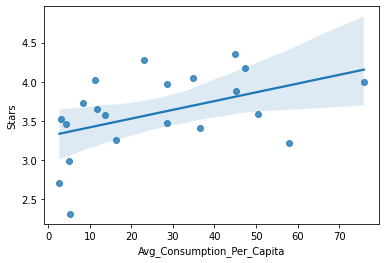

R-squared: 0.209874 P-value: 0.036753


In [18]:
#Now let's see what the correlation is between the consumption per capita and the star rating. Here I use seaborn to
#graph a linear regression, then scipy.stats to compute the statistics. Since scipy.stats doesn't provide R^2, I calculate
# it separately and print it, along with the p-value

sns.regplot(x='Avg_Consumption_Per_Capita', y='Stars', data=dfmeanstars)
regstats=stats.linregress(x=dfmeanstars['Avg_Consumption_Per_Capita'], y=dfmeanstars['Stars'])

print(f"R-squared: {regstats.rvalue**2:.6f} P-value: {regstats.pvalue:.6f}")


In [8]:
#Let's now look at boxplots of star ratings in Asian countries vs. the rest of the world. To do this,
#I'll first merge the Region column from dfcountries onto the filtered_dfrev dataframe from before.

regboxdf = filtered_dfrev.merge(dfcountries[['Country_ID','Region']], on='Country_ID', how= 'left')

#Next, I will replace all of the non-Asian countries with Region as "Rest of World"

regboxdf.loc[regboxdf['Region']!='Asia','Region'] = 'Rest of World'


In [9]:
#Some of the Star ratings are "NaN" though, so we shall drop those first (I have checked the database and confirmed
# these items never received a star rating).

regboxdf.dropna(subset=['Stars'], inplace=True)

                Stars                                              
                count      mean       std  min  25%  50%   75%  max
Region                                                             
Asia           3575.0  3.907287  1.060009  0.0  3.5  4.0  5.00  5.0
Rest of World   908.0  3.420859  1.280012  0.0  3.0  3.5  4.25  5.0


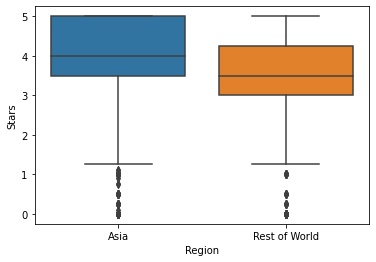

In [10]:
#Now let's do a boxplot and get some summary statistics

sns.boxplot(x='Region', y='Stars', data=regboxdf, order=['Asia','Rest of World'])
print(regboxdf[['Region', 'Stars']].groupby('Region').describe())

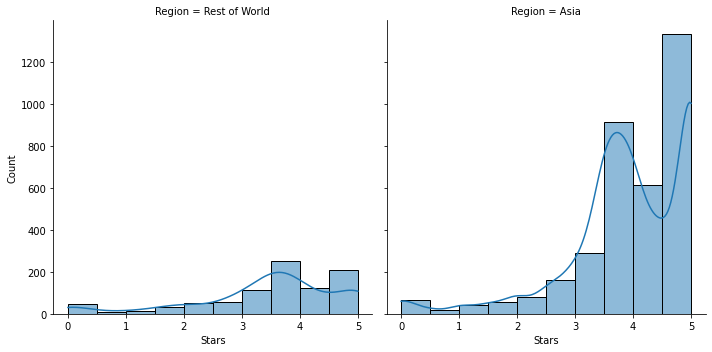

In [11]:
#Before we run a T-test, we need to see if the data is normally distributed. Let's put them in histograms.

sns.displot(data=regboxdf, x="Stars", col="Region", bins=10, kde=True)

In [12]:
#Even though the data distribution is non-parametric (looks more ordinal than normal), the sample size is large 
#enough to safely use a T-test. Still, let's do a Mann-Whitney U test instead just to be safe, and see if the
#difference between the two groups is statistically significant. I am keeping the T-test command commented out for reference.

asiastars = regboxdf[regboxdf['Region']=='Asia']['Stars']
reststars = regboxdf[regboxdf['Region']=='Rest of World']['Stars']
# stats.ttest_ind(asiastars, reststars)
stats.mannwhitneyu(asiastars, reststars)


MannwhitneyuResult(statistic=2011409.0, pvalue=1.7243020245331793e-29)

In [13]:
#Now let's do a boxplot with all countries' star ranking, with at least 50 reviews. This means filtering 
# the dfrev dataframe to 50 reviews, and merging the relevant columns from the dfcountries dataframe.

fiftyfilter_dfrev = dfrev.groupby("Country_ID").filter(lambda x: len(x) >= 50) 
anovaregbox = fiftyfilter_dfrev.merge(dfcountries[['Country_ID','Country']], on='Country_ID', how= 'left')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Thailand'),
  Text(2, 0, 'Vietnam'),
  Text(3, 0, 'Taiwan'),
  Text(4, 0, 'South Korea'),
  Text(5, 0, 'Japan'),
  Text(6, 0, 'Philippines'),
  Text(7, 0, 'Singapore'),
  Text(8, 0, 'Indonesia'),
  Text(9, 0, 'China'),
  Text(10, 0, 'Hong Kong'),
  Text(11, 0, 'Malaysia'),
  Text(12, 0, 'Canada'),
  Text(13, 0, 'United Kingdom')])

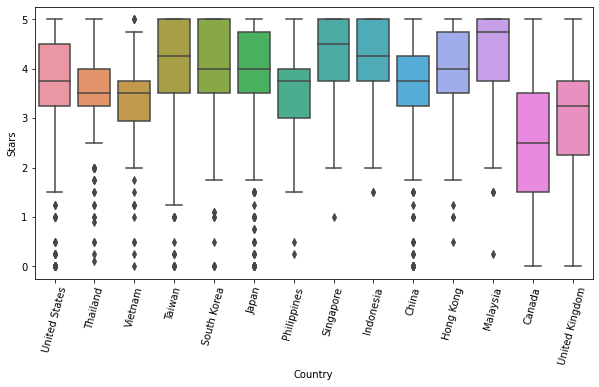

In [14]:
plt.figure(figsize = (10,5))
countriesboxplot = sns.boxplot(x='Country', y='Stars', data=anovaregbox)
plt.xticks(rotation=75)

In [15]:
# We can't just run an ANOVA test with the 'Country' and 'Stars' columns because the command compares values from column to column.
# Instead, I will make a "list of lists" using a for loop, with each list including the star values of each country.
# I will then compare those lists  to each other. Note that some of the star values are NaN, and those need to be dropped.

values = []
for country in anovaregbox['Country'].unique():
    _anovaregbox = anovaregbox[anovaregbox['Country']==country]
    values.append(_anovaregbox['Stars'].dropna())

In [16]:
# Here I perform a one-way ANOVA with the lists in values.

stats.f_oneway(*values)

F_onewayResult(statistic=34.92470122302282, pvalue=3.8347701788608804e-84)

In [17]:
# Like the T-test from earlier, the ANOVA test usually requires that the data be parametric, which this star rating data is not.
# The results should still be okay thanks to the large sample size, but just to be safe we can run a Kruskal–Wallis test instead
# (the ANOVA equivalent for non-normal data).

stats.kruskal(*values)

KruskalResult(statistic=439.99034702714357, pvalue=7.803818974337693e-86)